In [2]:
import numpy as np
import re
from csv import DictReader


fileLoc = "/home/vamsi/Downloads/fnc-1-baseline/fnc-1/"

text = []
with open(fileLoc+"words.txt") as f:
    text = f.read()
    text = re.sub('"','',text)
    text = re.sub(' ','',text)
    text = re.sub('\n','',text)
    text = text.split(',')
    
def readDict(fname):
        rows = []
        with open(fname, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)
        return rows
    


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

numFeatures = 6000

countVectorizer = CountVectorizer(max_features=numFeatures, stop_words=text)

newsBody = readDict(fileLoc+"train_bodies.csv")

instances = readDict(fileLoc+"train_stances.csv")

headers = {}
newsBodies = {}

for instance in instances:
    if instance['Headline'] not in headers:
        head_id = len(headers)
        headers[instance['Headline']] = head_id
    instance['Body ID'] = int(instance['Body ID'])
#print(heads)

for body in newsBody:
    newsBodies[int(body['Body ID'])] = body['articleBody']


In [4]:
heads = []
heads_track = {}
bodies = []
bodies_track = {}
body_ids = []
id_ref = {}
train_set = []
train_stances = []
cos_track = {}
test_heads = []
test_heads_track = {}
test_bodies = []
test_bodies_track = {}
test_body_ids = []
head_tfidf_track = {}
body_tfidf_track = {}

# Identify unique heads and bodies
for instance in instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in heads_track:
        heads.append(head)
        heads_track[head] = 1
    if body_id not in bodies_track:
        bodies.append(newsBodies[body_id])
        bodies_track[body_id] = 1
        body_ids.append(body_id)




In [5]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
bow = countVectorizer.fit_transform(heads + bodies) 

In [6]:
tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
tfreq = tfreq_vectorizer.transform(bow).toarray() 

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=numFeatures, stop_words=text).fit(heads + bodies + test_heads + test_bodies)  # Train and test sets

print(type(tfreq))

<class 'numpy.ndarray'>


In [8]:
        # Create reference dictionary
id_ref = {}
for i, elem in enumerate(heads + body_ids):
    id_ref[elem] = i
mapLabels = {'agree': 0, 'disagree': 1, 'discuss': 0, 'unrelated': 1}



In [9]:
from sklearn.metrics.pairwise import cosine_similarity

for instance in instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    head_tf = tfreq[id_ref[head]].reshape(1, -1)
    body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
    if head not in head_tfidf_track:
        head_tfidf = tfidf_vectorizer.transform([head]).toarray()
        head_tfidf_track[head] = head_tfidf
    else:
        head_tfidf = head_tfidf_track[head]
    if body_id not in body_tfidf_track:
        #print(body_id)
        body_tfidf = tfidf_vectorizer.transform([newsBodies[body_id]]).toarray()
        body_tfidf_track[body_id] = body_tfidf
    else:
        body_tfidf = body_tfidf_track[body_id]
    if (head, body_id) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body_id)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body_id)]
    feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    train_set.append(feat_vec)
    train_stances.append(mapLabels[instance['Stance']])

In [10]:
print(len(train_set),len(train_set[0]))
X= np.array(train_set)
Y= np.array(train_stances)

49972 12001


In [11]:
import numpy as np
from sklearn import linear_model

clf = linear_model.SGDClassifier()
clf.fit(X, Y)

/home/vamsi/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [12]:
# Initialise
print('Hi')
newsBody = readDict(fileLoc+"competition_test_bodies.csv")

test_instances = readDict(fileLoc+"competition_test_stances_unlabeled.csv")

headers = {}
bodies = {}

for instance in test_instances:
    if instance['Headline'] not in headers:
        head_id = len(headers)
        headers[instance['Headline']] = head_id
    instance['Body ID'] = int(instance['Body ID'])
#print(heads)

for body in newsBody:
    bodies[int(body['Body ID'])] = body['articleBody']



for instance in test_instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in test_heads_track:
        test_heads.append(head)
        test_heads_track[head] = 1
    if body_id not in test_bodies_track:
        test_bodies.append(bodies[body_id])
        test_bodies_track[body_id] = 1
        test_body_ids.append(body_id)

test_set = []
heads_track = {}
bodies_track = {}
cos_track = {}

# Process test set
for instance in test_instances:
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in heads_track:
        head_bow = countVectorizer.transform([head]).toarray()
        head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
        head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
        heads_track[head] = (head_tf, head_tfidf)
    else:
        head_tf = heads_track[head][0]
        head_tfidf = heads_track[head][1]
    if body_id not in bodies_track:
        body_bow = countVectorizer.transform([bodies[body_id]]).toarray()
        body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
        body_tfidf = tfidf_vectorizer.transform([bodies[body_id]]).toarray().reshape(1, -1)
        bodies_track[body_id] = (body_tf, body_tfidf)
    else:
        body_tf = bodies_track[body_id][0]
        body_tfidf = bodies_track[body_id][1]
    if (head, body_id) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body_id)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body_id)]
    feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    test_set.append(feat_vec)



Hi


In [13]:
test_pred = clf.predict(test_set)

In [14]:
actualLabels = readDict(fileLoc+"competition_test_stances.csv")

actualStances = []

for r in actualLabels:
   # print(r['Stance'])
    #print(label_ref[r])
    actualStances.append(mapLabels[r['Stance']])
    
count =0

for i in range(len(actualStances)):
    if actualStances[i] == test_pred[i]:
        count += 1
        
print(count/len(actualStances))

0.9135875339393223


In [15]:
print(sum(actualStances)/len(actualStances))

0.7494589383386456


In [22]:
alphas = [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
accuracy  = []
for alpha in alphas:
    clf = linear_model.SGDClassifier(alpha=alpha)
    clf.fit(X, Y)
    test_pred = clf.predict(test_set)
    count = 0
    for i in range(len(actualStances)):
        if actualStances[i] == test_pred[i]:
            count += 1
    accuracy.append((count/len(actualStances)))

/home/vamsi/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [30]:
accuracy[0] =  0.870194782198088

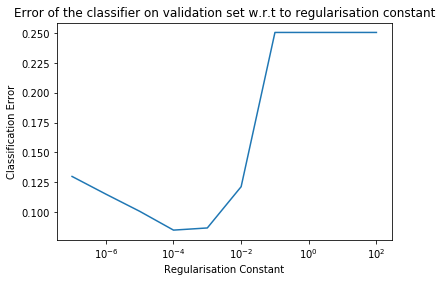

In [34]:

import matplotlib.pyplot as plt
#import seaborn as sns

#plt.figure(figsize=(20, 4))
error = [1-a for a in accuracy]
#plt.subplot(1, 2, 1)
plt.plot(alphas[:len(alphas)-1], error[:len(alphas)-1])
plt.xlabel('Regularisation constant in log base 10')
plt.ylabel('Error')
plt.title('Error of the classifier on validation set w.r.t to regularisation constant')

ax = plt.gca()
ax.set_xticklabels([])
ax.set_xlabel('Regularisation Constant')
ax.set_ylabel('Classification Error')
ax.set_xscale('log')
plt.show()

In [36]:
print(accuracy)

[0.870194782198088, 0.8850194782198088, 0.8994215558965883, 0.9152008814386338, 0.9133907842442844, 0.8788021878566088, 0.7494589383386456, 0.7494589383386456, 0.7494589383386456, 0.7494589383386456, 0.2505410616613544]
